In [0]:
# importing necessary libraries
from scipy.misc import imread,imresize

import os
import numpy as np
import random
import matplotlib.pyplot as plt 

from scipy import pi
from itertools import islice
import numpy
import scipy.misc
import random

import tensorflow as tf
import scipy

import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import driving_data
#import model

import tensorflow as tf
import scipy.misc
#import model
import cv2
from subprocess import call
import math


In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
from __future__ import division

# read images and steering angles from driving_dataset folder
DATA_FOLDER = 'driving_dataset/' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')
LIMIT=None

split =0.8
X = []
y = []

with open(TRAIN_FILE) as fp:
    for line in islice(fp, LIMIT):
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )
        
y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*0.7)

train_y = y[:split_index]
test_y = y[split_index:]

          

Completed processing data.txt


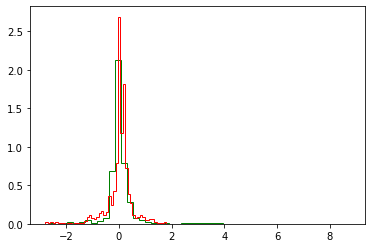

In [0]:

# PDF of train and test 'y' values. 
plt.hist(train_y, bins=50, density=True, color='green', histtype ='step');
plt.hist(test_y, bins=50, density=True, color='red', histtype ='step');
plt.show()




In [0]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )


Test_MSE(MEAN):0.241561
Test_MSE(ZERO):0.241107


In [0]:


xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        # Saving the location of each image in xs
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        
        # Converting steering angle which we need to predict from radians
        # to degrees for fast computation 
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)

# To change the train and test ratio do it here
# Here Train -> 80% and Test -> 20%
train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

def LoadTrainBatch(batch_size):
    # Train batch pointer allows we use subsequent ahead images for train 
    # Rather than using random images from train data as we train the model 
    # on batches of data rather thatn whole data at each epoch
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        #Resizing and Converting image in ideal form to train
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

In [0]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])
# using liniear activation to keep the steering angle in sync
y = tf.multiply(tf.keras.activations.linear(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
import model
LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(learning_rate=10**-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
    for i in range(int(driving_data.num_images/batch_size)):
        xs, ys = driving_data.LoadTrainBatch(batch_size)
        train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
        if i % 10 == 0:
            xs, ys = driving_data.LoadValBatch(batch_size)
            loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
            print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

            # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
        summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
    print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0, Step: 0, Loss: 12.6032
Epoch: 0, Step: 10, Loss: 12.5065
Epoch: 0, Step: 20, Loss: 12.1341
Epoch: 0, Step: 30, Loss: 11.8907
Epoch: 0, Step: 40, Loss: 11.7156
Epoch: 0, Step: 50, Loss: 11.5999
Epoch: 0, Step: 60, Loss: 11.6133
Epoch: 0, Step: 70, Loss: 12.3305
Epoch: 0, Step: 80, Loss: 12.8642
Epoch: 0, Step: 90, Loss: 11.2677
Epoch: 0, Step: 100, Loss: 10.9111
Epoch: 0, Step: 110, Loss: 10.7325
Epoch: 0, Step: 120, Loss: 10.6193
Epoch: 0, Step: 130, Loss: 10.4851
Epoch: 0, Step: 140, Loss: 10.3711
Epoch: 0, Step: 150, Loss: 10.3138
Epoch: 0, Step: 160, Loss: 10.1758
Epoch: 0, Step: 170, Loss: 10.0006
Epoch: 0, Step: 180, Loss: 9.91232
Epoch: 0, Step: 190, Loss: 10.0919
Epoch: 0, Step: 200, Loss: 9.6537
Epoch: 0, Step: 210, Loss: 9.62125
Epoch: 0, Step: 220, Loss: 9.39145
Epoch: 0, Step: 230, Loss: 9.28093
Epoch: 0, Step: 240, Loss: 9.17358
Epoch: 0, Step: 250, Loss: 9.06818
Epoch: 0, Step: 260, Loss: 8

Epoch: 2, Step: 240, Loss: 4.74738
Epoch: 2, Step: 250, Loss: 4.87128
Epoch: 2, Step: 260, Loss: 5.8819
Epoch: 2, Step: 270, Loss: 6.13278
Epoch: 2, Step: 280, Loss: 4.65268
Epoch: 2, Step: 290, Loss: 4.59597
Epoch: 2, Step: 300, Loss: 4.49821
Epoch: 2, Step: 310, Loss: 4.48606
Epoch: 2, Step: 320, Loss: 4.44086
Epoch: 2, Step: 330, Loss: 4.43653
Epoch: 2, Step: 340, Loss: 4.44939
Epoch: 2, Step: 350, Loss: 4.38328
Epoch: 2, Step: 360, Loss: 4.32292
Epoch: 2, Step: 370, Loss: 4.35068
Epoch: 2, Step: 380, Loss: 4.61338
Epoch: 2, Step: 390, Loss: 4.30796
Epoch: 2, Step: 400, Loss: 4.26221
Epoch: 2, Step: 410, Loss: 4.15827
Epoch: 2, Step: 420, Loss: 4.13045
Epoch: 2, Step: 430, Loss: 4.1026
Epoch: 2, Step: 440, Loss: 4.07581
Epoch: 2, Step: 450, Loss: 4.12317
Epoch: 2, Step: 460, Loss: 9.74478
Epoch: 2, Step: 470, Loss: 4.23983
Epoch: 2, Step: 480, Loss: 3.98065
Epoch: 2, Step: 490, Loss: 3.94932
Epoch: 2, Step: 500, Loss: 3.92059
Epoch: 2, Step: 510, Loss: 3.90259
Epoch: 2, Step: 520, L

Epoch: 4, Step: 560, Loss: 2.78768
Epoch: 4, Step: 570, Loss: 3.03545
Epoch: 4, Step: 580, Loss: 2.84558
Epoch: 4, Step: 590, Loss: 2.65587
Epoch: 4, Step: 600, Loss: 2.63959
Epoch: 4, Step: 610, Loss: 2.6298
Epoch: 4, Step: 620, Loss: 2.61971
Epoch: 4, Step: 630, Loss: 2.61005
Epoch: 4, Step: 640, Loss: 3.12249
Epoch: 4, Step: 650, Loss: 7.81226
Epoch: 4, Step: 660, Loss: 2.63607
Epoch: 4, Step: 670, Loss: 2.57688
Epoch: 4, Step: 680, Loss: 2.56297
Epoch: 4, Step: 690, Loss: 2.55373
Epoch: 4, Step: 700, Loss: 2.54786
Epoch: 4, Step: 710, Loss: 2.537
Epoch: 4, Step: 720, Loss: 2.53806
Epoch: 4, Step: 730, Loss: 2.52558
Epoch: 4, Step: 740, Loss: 2.51723
Epoch: 4, Step: 750, Loss: 2.50746
Epoch: 4, Step: 760, Loss: 2.50418
Epoch: 4, Step: 770, Loss: 2.49172
Epoch: 4, Step: 780, Loss: 2.48496
Epoch: 4, Step: 790, Loss: 2.47736
Epoch: 4, Step: 800, Loss: 2.46673
Epoch: 4, Step: 810, Loss: 2.45535
Epoch: 4, Step: 820, Loss: 2.44889
Epoch: 4, Step: 830, Loss: 2.44216
Epoch: 4, Step: 840, Lo

Epoch: 6, Step: 890, Loss: 1.91987
Epoch: 6, Step: 900, Loss: 1.9145
Epoch: 6, Step: 910, Loss: 1.91232
Epoch: 6, Step: 920, Loss: 1.90764
Epoch: 6, Step: 930, Loss: 1.90225
Epoch: 6, Step: 940, Loss: 1.89024
Epoch: 6, Step: 950, Loss: 1.88923
Epoch: 6, Step: 960, Loss: 1.89782
Epoch: 6, Step: 970, Loss: 1.88946
Epoch: 6, Step: 980, Loss: 1.87408
Epoch: 6, Step: 990, Loss: 1.86175
Epoch: 6, Step: 1000, Loss: 1.85702
Epoch: 6, Step: 1010, Loss: 1.8512
Epoch: 6, Step: 1020, Loss: 1.84638
Epoch: 6, Step: 1030, Loss: 1.84232
Epoch: 6, Step: 1040, Loss: 1.83346
Epoch: 6, Step: 1050, Loss: 1.82879
Model saved in file: ./save\model.ckpt
Epoch: 7, Step: 700, Loss: 1.82989
Epoch: 7, Step: 710, Loss: 1.82323
Epoch: 7, Step: 720, Loss: 1.81999
Epoch: 7, Step: 730, Loss: 1.81001
Epoch: 7, Step: 740, Loss: 1.80811
Epoch: 7, Step: 750, Loss: 1.80225
Epoch: 7, Step: 760, Loss: 1.79434
Epoch: 7, Step: 770, Loss: 1.84763
Epoch: 7, Step: 780, Loss: 1.82532
Epoch: 7, Step: 790, Loss: 5.80291
Epoch: 7, St

Epoch: 8, Step: 1200, Loss: 1.41306
Epoch: 8, Step: 1210, Loss: 1.42878
Epoch: 8, Step: 1220, Loss: 1.42535
Epoch: 8, Step: 1230, Loss: 1.39932
Epoch: 8, Step: 1240, Loss: 1.40407
Epoch: 8, Step: 1250, Loss: 1.40873
Model saved in file: ./save\model.ckpt
Epoch: 9, Step: 900, Loss: 1.3947
Epoch: 9, Step: 910, Loss: 1.38867
Epoch: 9, Step: 920, Loss: 1.37295
Epoch: 9, Step: 930, Loss: 1.36803
Epoch: 9, Step: 940, Loss: 1.36712
Epoch: 9, Step: 950, Loss: 1.36441
Epoch: 9, Step: 960, Loss: 1.4055
Epoch: 9, Step: 970, Loss: 1.37889
Epoch: 9, Step: 980, Loss: 6.4947
Epoch: 9, Step: 990, Loss: 1.82138
Epoch: 9, Step: 1000, Loss: 1.3402
Epoch: 9, Step: 1010, Loss: 1.34877
Epoch: 9, Step: 1020, Loss: 1.37463
Epoch: 9, Step: 1030, Loss: 1.37891
Epoch: 9, Step: 1040, Loss: 1.32531
Epoch: 9, Step: 1050, Loss: 1.43116
Epoch: 9, Step: 1060, Loss: 1.39786
Epoch: 9, Step: 1070, Loss: 1.30678
Epoch: 9, Step: 1080, Loss: 1.31283
Epoch: 9, Step: 1090, Loss: 1.33096
Epoch: 9, Step: 1100, Loss: 1.30154
Epo

Epoch: 11, Step: 1110, Loss: 1.02765
Epoch: 11, Step: 1120, Loss: 1.03544
Epoch: 11, Step: 1130, Loss: 1.01557
Epoch: 11, Step: 1140, Loss: 1.01379
Epoch: 11, Step: 1150, Loss: 1.1325
Epoch: 11, Step: 1160, Loss: 1.11027
Epoch: 11, Step: 1170, Loss: 6.68562
Epoch: 11, Step: 1180, Loss: 1.00268
Epoch: 11, Step: 1190, Loss: 0.987127
Epoch: 11, Step: 1200, Loss: 0.994316
Epoch: 11, Step: 1210, Loss: 1.02971
Epoch: 11, Step: 1220, Loss: 0.984957
Epoch: 11, Step: 1230, Loss: 0.980731
Epoch: 11, Step: 1240, Loss: 1.17717
Epoch: 11, Step: 1250, Loss: 1.05872
Epoch: 11, Step: 1260, Loss: 0.966096
Epoch: 11, Step: 1270, Loss: 1.02867
Epoch: 11, Step: 1280, Loss: 0.960032
Epoch: 11, Step: 1290, Loss: 0.971976
Epoch: 11, Step: 1300, Loss: 0.977685
Epoch: 11, Step: 1310, Loss: 1.04196
Epoch: 11, Step: 1320, Loss: 0.982636
Epoch: 11, Step: 1330, Loss: 1.03354
Epoch: 11, Step: 1340, Loss: 0.973643
Epoch: 11, Step: 1350, Loss: 0.976026
Epoch: 11, Step: 1360, Loss: 0.94916
Epoch: 11, Step: 1370, Loss:

Epoch: 13, Step: 1380, Loss: 0.709498
Epoch: 13, Step: 1390, Loss: 0.754734
Epoch: 13, Step: 1400, Loss: 0.767858
Epoch: 13, Step: 1410, Loss: 0.767468
Epoch: 13, Step: 1420, Loss: 0.7151
Epoch: 13, Step: 1430, Loss: 0.824432
Epoch: 13, Step: 1440, Loss: 0.713365
Epoch: 13, Step: 1450, Loss: 0.698095
Epoch: 13, Step: 1460, Loss: 0.730518
Epoch: 13, Step: 1470, Loss: 0.699257
Epoch: 13, Step: 1480, Loss: 0.692306
Epoch: 13, Step: 1490, Loss: 0.747265
Epoch: 13, Step: 1500, Loss: 0.776979
Epoch: 13, Step: 1510, Loss: 0.736061
Epoch: 13, Step: 1520, Loss: 0.770648
Epoch: 13, Step: 1530, Loss: 0.76685
Epoch: 13, Step: 1540, Loss: 0.821908
Epoch: 13, Step: 1550, Loss: 0.669298
Epoch: 13, Step: 1560, Loss: 0.686486
Epoch: 13, Step: 1570, Loss: 0.678588
Epoch: 13, Step: 1580, Loss: 0.67826
Epoch: 13, Step: 1590, Loss: 0.712571
Epoch: 13, Step: 1600, Loss: 0.68953
Epoch: 13, Step: 1610, Loss: 0.662837
Epoch: 13, Step: 1620, Loss: 0.664436
Epoch: 13, Step: 1630, Loss: 0.65188
Epoch: 13, Step: 1

Epoch: 15, Step: 1620, Loss: 0.624739
Epoch: 15, Step: 1630, Loss: 0.498263
Epoch: 15, Step: 1640, Loss: 0.512733
Epoch: 15, Step: 1650, Loss: 0.519346
Epoch: 15, Step: 1660, Loss: 0.502324
Epoch: 15, Step: 1670, Loss: 0.503632
Epoch: 15, Step: 1680, Loss: 0.524258
Epoch: 15, Step: 1690, Loss: 0.528823
Epoch: 15, Step: 1700, Loss: 0.565726
Epoch: 15, Step: 1710, Loss: 0.601361
Epoch: 15, Step: 1720, Loss: 0.494043
Epoch: 15, Step: 1730, Loss: 0.503309
Epoch: 15, Step: 1740, Loss: 0.491052
Epoch: 15, Step: 1750, Loss: 0.491968
Epoch: 15, Step: 1760, Loss: 0.493066
Epoch: 15, Step: 1770, Loss: 0.491239
Epoch: 15, Step: 1780, Loss: 0.485691
Epoch: 15, Step: 1790, Loss: 0.479791
Epoch: 15, Step: 1800, Loss: 0.484623
Epoch: 15, Step: 1810, Loss: 0.479019
Epoch: 15, Step: 1820, Loss: 0.478642
Epoch: 15, Step: 1830, Loss: 0.462907
Epoch: 15, Step: 1840, Loss: 0.479124
Epoch: 15, Step: 1850, Loss: 0.487471
Epoch: 15, Step: 1860, Loss: 0.558576
Epoch: 15, Step: 1870, Loss: 0.753588
Epoch: 15, S

Epoch: 17, Step: 1910, Loss: 0.378476
Epoch: 17, Step: 1920, Loss: 0.374224
Epoch: 17, Step: 1930, Loss: 0.374538
Epoch: 17, Step: 1940, Loss: 0.369316
Epoch: 17, Step: 1950, Loss: 0.368452
Epoch: 17, Step: 1960, Loss: 0.366107
Epoch: 17, Step: 1970, Loss: 0.35949
Epoch: 17, Step: 1980, Loss: 0.349231
Epoch: 17, Step: 1990, Loss: 0.344869
Epoch: 17, Step: 2000, Loss: 0.341697
Epoch: 17, Step: 2010, Loss: 0.345207
Epoch: 17, Step: 2020, Loss: 0.365681
Epoch: 17, Step: 2030, Loss: 0.342539
Epoch: 17, Step: 2040, Loss: 0.362405
Epoch: 17, Step: 2050, Loss: 0.409079
Epoch: 17, Step: 2060, Loss: 0.569446
Epoch: 17, Step: 2070, Loss: 0.49901
Epoch: 17, Step: 2080, Loss: 0.405319
Epoch: 17, Step: 2090, Loss: 0.346749
Epoch: 17, Step: 2100, Loss: 0.339713
Epoch: 17, Step: 2110, Loss: 0.388333
Epoch: 17, Step: 2120, Loss: 0.569813
Epoch: 17, Step: 2130, Loss: 0.676618
Epoch: 17, Step: 2140, Loss: 0.470851
Epoch: 17, Step: 2150, Loss: 0.37461
Model saved in file: ./save\model.ckpt
Epoch: 18, Ste

Epoch: 19, Step: 2210, Loss: 0.278077
Epoch: 19, Step: 2220, Loss: 0.31932
Epoch: 19, Step: 2230, Loss: 0.299996
Epoch: 19, Step: 2240, Loss: 0.492654
Epoch: 19, Step: 2250, Loss: 0.830622
Epoch: 19, Step: 2260, Loss: 0.613766
Epoch: 19, Step: 2270, Loss: 0.358008
Epoch: 19, Step: 2280, Loss: 0.268886
Epoch: 19, Step: 2290, Loss: 0.280283
Epoch: 19, Step: 2300, Loss: 0.323716
Epoch: 19, Step: 2310, Loss: 0.296275
Epoch: 19, Step: 2320, Loss: 0.275745
Epoch: 19, Step: 2330, Loss: 0.328634
Epoch: 19, Step: 2340, Loss: 0.281264
Epoch: 19, Step: 2350, Loss: 0.279654
Model saved in file: ./save\model.ckpt
Epoch: 20, Step: 2000, Loss: 0.268584
Epoch: 20, Step: 2010, Loss: 0.273791
Epoch: 20, Step: 2020, Loss: 0.313955
Epoch: 20, Step: 2030, Loss: 0.295114
Epoch: 20, Step: 2040, Loss: 0.318303
Epoch: 20, Step: 2050, Loss: 0.412606
Epoch: 20, Step: 2060, Loss: 0.316967
Epoch: 20, Step: 2070, Loss: 0.579526
Epoch: 20, Step: 2080, Loss: 0.305817
Epoch: 20, Step: 2090, Loss: 0.444379
Epoch: 20, S

Epoch: 21, Step: 2470, Loss: 0.225085
Epoch: 21, Step: 2480, Loss: 0.242486
Epoch: 21, Step: 2490, Loss: 0.302269
Epoch: 21, Step: 2500, Loss: 0.559689
Epoch: 21, Step: 2510, Loss: 0.880924
Epoch: 21, Step: 2520, Loss: 0.29988
Epoch: 21, Step: 2530, Loss: 0.281805
Epoch: 21, Step: 2540, Loss: 0.22528
Epoch: 21, Step: 2550, Loss: 0.220914
Model saved in file: ./save\model.ckpt
Epoch: 22, Step: 2200, Loss: 0.224894
Epoch: 22, Step: 2210, Loss: 0.228601
Epoch: 22, Step: 2220, Loss: 0.252545
Epoch: 22, Step: 2230, Loss: 0.254038
Epoch: 22, Step: 2240, Loss: 0.221794
Epoch: 22, Step: 2250, Loss: 0.325209
Epoch: 22, Step: 2260, Loss: 0.556856
Epoch: 22, Step: 2270, Loss: 0.305211
Epoch: 22, Step: 2280, Loss: 0.432986
Epoch: 22, Step: 2290, Loss: 0.34529
Epoch: 22, Step: 2300, Loss: 0.333061
Epoch: 22, Step: 2310, Loss: 0.289068
Epoch: 22, Step: 2320, Loss: 0.277824
Epoch: 22, Step: 2330, Loss: 0.266053
Epoch: 22, Step: 2340, Loss: 5.35031
Epoch: 22, Step: 2350, Loss: 0.464238
Epoch: 22, Step

Epoch: 23, Step: 2710, Loss: 0.230575
Epoch: 23, Step: 2720, Loss: 0.241738
Epoch: 23, Step: 2730, Loss: 0.197419
Epoch: 23, Step: 2740, Loss: 0.201834
Epoch: 23, Step: 2750, Loss: 0.207198
Model saved in file: ./save\model.ckpt
Epoch: 24, Step: 2400, Loss: 0.213644
Epoch: 24, Step: 2410, Loss: 0.252715
Epoch: 24, Step: 2420, Loss: 0.217716
Epoch: 24, Step: 2430, Loss: 0.298402
Epoch: 24, Step: 2440, Loss: 0.41243
Epoch: 24, Step: 2450, Loss: 0.4545
Epoch: 24, Step: 2460, Loss: 0.394901
Epoch: 24, Step: 2470, Loss: 0.264824
Epoch: 24, Step: 2480, Loss: 0.217687
Epoch: 24, Step: 2490, Loss: 0.215365
Epoch: 24, Step: 2500, Loss: 0.214128
Epoch: 24, Step: 2510, Loss: 0.210213
Epoch: 24, Step: 2520, Loss: 0.396075
Epoch: 24, Step: 2530, Loss: 5.41308
Epoch: 24, Step: 2540, Loss: 0.293024
Epoch: 24, Step: 2550, Loss: 0.193803
Epoch: 24, Step: 2560, Loss: 0.196951
Epoch: 24, Step: 2570, Loss: 0.203672
Epoch: 24, Step: 2580, Loss: 0.2031
Epoch: 24, Step: 2590, Loss: 0.194221
Epoch: 24, Step: 

Epoch: 26, Step: 2610, Loss: 0.179541
Epoch: 26, Step: 2620, Loss: 0.209261
Epoch: 26, Step: 2630, Loss: 0.320912
Epoch: 26, Step: 2640, Loss: 0.404794
Epoch: 26, Step: 2650, Loss: 0.396545
Epoch: 26, Step: 2660, Loss: 0.203008
Epoch: 26, Step: 2670, Loss: 0.198913
Epoch: 26, Step: 2680, Loss: 0.221298
Epoch: 26, Step: 2690, Loss: 0.303872
Epoch: 26, Step: 2700, Loss: 0.236756
Epoch: 26, Step: 2710, Loss: 1.36118
Epoch: 26, Step: 2720, Loss: 5.42474
Epoch: 26, Step: 2730, Loss: 0.203539
Epoch: 26, Step: 2740, Loss: 0.182063
Epoch: 26, Step: 2750, Loss: 0.186124
Epoch: 26, Step: 2760, Loss: 0.180736
Epoch: 26, Step: 2770, Loss: 0.196575
Epoch: 26, Step: 2780, Loss: 0.24756
Epoch: 26, Step: 2790, Loss: 0.283608
Epoch: 26, Step: 2800, Loss: 0.289048
Epoch: 26, Step: 2810, Loss: 0.528654
Epoch: 26, Step: 2820, Loss: 0.434504
Epoch: 26, Step: 2830, Loss: 1.25551
Epoch: 26, Step: 2840, Loss: 0.257133
Epoch: 26, Step: 2850, Loss: 0.218366
Epoch: 26, Step: 2860, Loss: 0.339073
Epoch: 26, Step:

Epoch: 28, Step: 2910, Loss: 3.67968
Epoch: 28, Step: 2920, Loss: 0.169201
Epoch: 28, Step: 2930, Loss: 0.166632
Epoch: 28, Step: 2940, Loss: 0.167941
Epoch: 28, Step: 2950, Loss: 0.171942
Epoch: 28, Step: 2960, Loss: 0.170841
Epoch: 28, Step: 2970, Loss: 0.202463
Epoch: 28, Step: 2980, Loss: 0.191064
Epoch: 28, Step: 2990, Loss: 0.175686
Epoch: 28, Step: 3000, Loss: 0.180522
Epoch: 28, Step: 3010, Loss: 0.174886
Epoch: 28, Step: 3020, Loss: 0.200436
Epoch: 28, Step: 3030, Loss: 0.179322
Epoch: 28, Step: 3040, Loss: 0.184674
Epoch: 28, Step: 3050, Loss: 0.18494
Epoch: 28, Step: 3060, Loss: 0.172194
Epoch: 28, Step: 3070, Loss: 0.185575
Epoch: 28, Step: 3080, Loss: 0.21795
Epoch: 28, Step: 3090, Loss: 0.167406
Epoch: 28, Step: 3100, Loss: 0.164305
Epoch: 28, Step: 3110, Loss: 0.179115
Epoch: 28, Step: 3120, Loss: 0.17736
Epoch: 28, Step: 3130, Loss: 0.177487
Epoch: 28, Step: 3140, Loss: 0.177666
Epoch: 28, Step: 3150, Loss: 0.176797
Epoch: 28, Step: 3160, Loss: 0.174133
Epoch: 28, Step:

In [6]:
#pip3 install opencv-python

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)
        


#get number of images
num_images = len(xs)


#i = math.ceil(num_images*0.7)
i = 0
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


Streaming output truncated to the last 5000 lines.

Steering angle: -2.4196636691423636 (pred)	0.71 (actual)

Steering angle: -2.5559148440267165 (pred)	1.01 (actual)

Steering angle: -2.8005799040593895 (pred)	1.01 (actual)

Steering angle: -3.0067201358522517 (pred)	0.61 (actual)

Steering angle: -3.216603311310281 (pred)	0.61 (actual)

Steering angle: -2.0725227196710505 (pred)	0.71 (actual)

Steering angle: -0.650041056141161 (pred)	0.81 (actual)

Steering angle: -0.37535816847992826 (pred)	0.81 (actual)

Steering angle: -0.4977807716159443 (pred)	0.81 (actual)

Steering angle: -0.5615422950653058 (pred)	0.81 (actual)

Steering angle: -0.6371132155896194 (pred)	1.01 (actual)

Steering angle: -0.6308115123066363 (pred)	1.71 (actual)

Steering angle: -0.5519219736193428 (pred)	2.22 (actual)

Steering angle: -0.9934612600621097 (pred)	2.32 (actual)

Steering angle: -1.5449298798752928 (pred)	2.32 (actual)

Steering angle: -1.7688021365271547 (pred)	2.32 (actual)

Steering angle: -2.30

# CONCLUSION:

1. THE STEETING ANGLE AND THE PATH ANGLE COINCIDES FARE WELL AND IS ALWAYS IN SYNC
2. SLIGHT ERRORS AND GLITCHES ARE NOTICES AS A RESULT OF UNEAVEN ACCELERATION AND DRIVING PATH WITH SLIGHT NON-LINEAR CHARECTERISTICS WHILE IN TRAFFIC
3. THE ERROR CAN BE RECTIFIED  BY ADDING THE CENTERNET DATA OF THE CAR AND OBSTACLES TO THE AUTOPILOT .
